matplotlib 3.10.6 downgraded to 3.7.5 to work with pycomplexheatmap

## 1.Load Data

Load the data into your chosen programming language (R or python recommended). 

- What size is your expression matrix? 
- How many genes does it include? 
- How much variation do you see in the data? 

To answer these questions, 
- log-scale the data, 
- calculate per-gene median 
- expression ranges, 
- then make a density plot showing those results. 
- Summarize your findings.


Input sequence provided is already in string format. No operation performed
Input sequence provided is already in string format. No operation performed


Expr.shape (raw): (43363, 117) 

Querying...


27 input query terms found dup hits:	[('ENSG00000175711', 2), ('ENSG00000188660', 2), ('ENSG00000226506', 2), ('ENSG00000226519', 2), ('E
1224 input query terms found no hit:	['ENSG00000112096', 'ENSG00000116883', 'ENSG00000130489', 'ENSG00000130723', 'ENSG00000131484', 'ENS


Expr.shape (with gene names): (32059, 116) 

Gene ranges:
 GeneName
5S_rRNA     0.536744
7SK         0.618572
A1BG        0.830834
A1BG-AS1    0.503588
A1CF        1.482642
dtype: float64 

Gene medians:
 GeneName
5S_rRNA     0.147352
7SK         0.185608
A1BG        1.657726
A1BG-AS1    1.711468
A1CF        0.849963
dtype: float64 



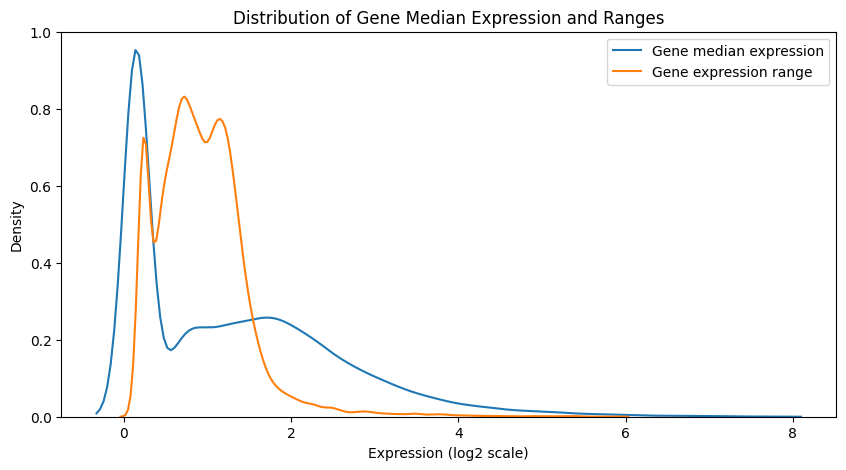

'Summary of findings\nThe distribution of gene median expressions is centered at zero and is skewed to the right. \nThis means that a majority of genes with a median near zero are either lowly expressed or off.\nThe genes in the right tail are expressed at moderate to high rates across samples. \n\nThe distribution of gene expression ranges is bimodal. Still, most of the ranges fall between zero to two,\nmeaning that most of the genes are fairly stable across samples and likely have a housekeeping-like role.\n'

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import mygene

# Load gene expression and metadata into dataframes
expr = pd.read_csv("data/SRP075806/SRP075806.tsv", sep='\t')
meta = pd.read_csv("data/SRP075806/metadata_SRP075806.tsv", sep='\t')

# What size is the expression matrix?
# 43363 genes and 117 samples
print("Expr.shape (raw):", expr.shape, '\n')

# Query mygene for gene names
expr = expr.set_index("Gene")
expr.index = expr.index.str.split('.').str[0]
mg = mygene.MyGeneInfo()
print('Querying...')
res = mg.querymany(expr.index.tolist(),
                   scopes="ensembl.gene",
                   fields="symbol",
                   species="human")

# Mapping dataframe
mapping = (pd.DataFrame(res)
             .loc[:, ["query", "symbol"]]
             .dropna()
             .rename(columns={"query": "Ensembl", "symbol": "GeneName"}))

# Use mapping dataframe to build expression matrix
expr = expr.merge(mapping, left_index=True, right_on="Ensembl")
expr = expr.drop(columns="Ensembl").set_index("GeneName")

# If multiple Ensembl IDs map to the same symbol, combine the rows
expr = expr.groupby(expr.index).mean()

print("Expr.shape (with gene names):", expr.shape, '\n')

expr_log = np.log2(expr+1)

# per-gene median and expression range
gene_medians = expr_log.median(axis=1)
gene_ranges = expr_log.max(axis=1) - expr_log.min(axis=1)
print("Gene ranges:\n", gene_ranges.head(), '\n')
print("Gene medians:\n", gene_medians.head(), '\n')

# Density plot
plt.figure(figsize=(10,5))
sns.kdeplot(gene_medians, label="Gene median expression")
sns.kdeplot(gene_ranges, label="Gene expression range")
plt.xlabel("Expression (log2 scale)")
plt.ylabel("Density")
plt.title("Distribution of Gene Median Expression and Ranges")
plt.legend()
plt.show()

"""Summary of findings
The distribution of gene median expressions is centered at zero and is skewed to the right. 
This means that a majority of genes with a median near zero are either lowly expressed or off.
The genes in the right tail are expressed at moderate to high rates across samples. 

The distribution of gene expression ranges is bimodal. Still, most of the ranges fall between zero to two,
meaning that most of the genes are fairly stable across samples and likely have a housekeeping-like role.
"""

## 2. Generate a PCA plot

d:\projects\cgs4144_project\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
d:\projects\cgs4144_project\.venv\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


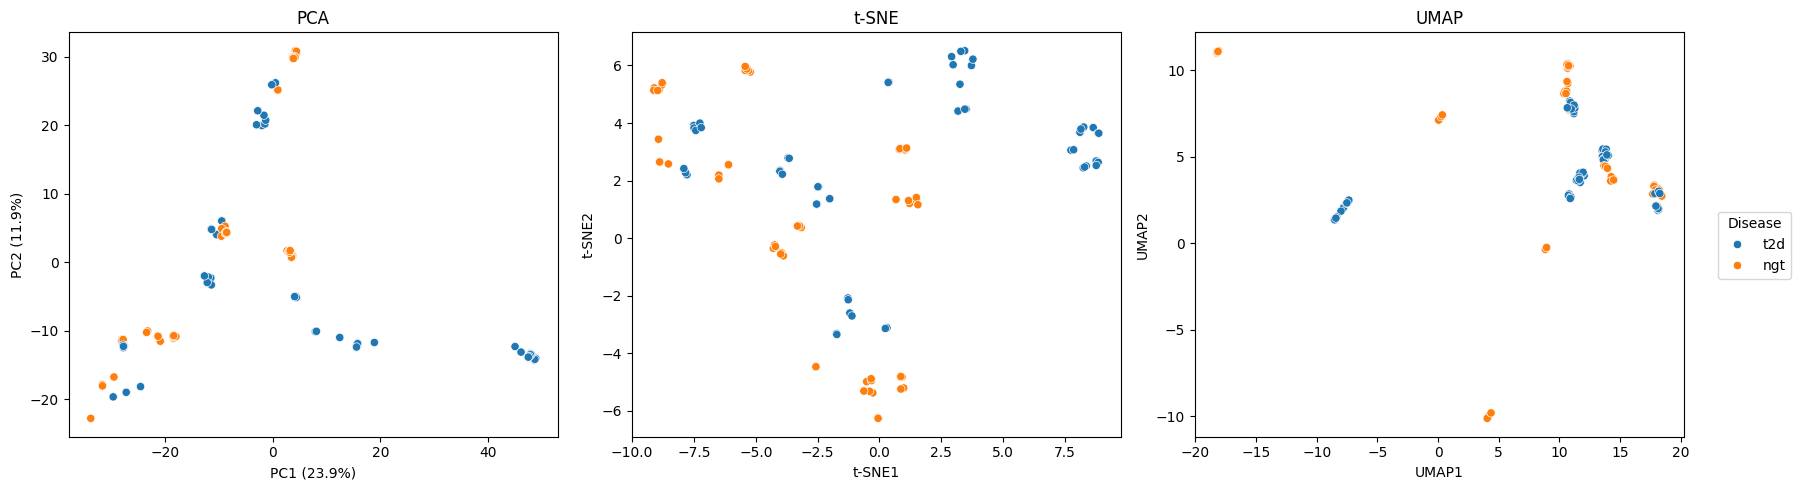

In [2]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap.umap_ as umap

meta = meta.set_index('refinebio_accession_code')
meta = meta.loc[expr_log.columns]

labels = meta['refinebio_disease']
labels

pca = PCA(n_components=2, random_state=13)
pca_coords = pca.fit_transform(expr_log.T)

tsne = TSNE(n_components=2, perplexity=30, random_state=13)
tsne_coords = tsne.fit_transform(expr_log.T)

um = umap.UMAP(n_neighbors=15, min_dist=0.1, random_state=13)
umap_coords = um.fit_transform(expr_log.T)


fig, axes = plt.subplots(1, 3, figsize=(18, 5))

sns.scatterplot(x=pca_coords[:,0], y=pca_coords[:,1], hue=labels, ax=axes[0])
axes[0].set_xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)")
axes[0].set_ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)")
axes[0].set_title("PCA")
axes[0].legend_.remove()

sns.scatterplot(x=tsne_coords[:,0], y=tsne_coords[:,1], hue=labels, ax=axes[1])
axes[1].set_xlabel("t-SNE1")
axes[1].set_ylabel("t-SNE2")
axes[1].set_title("t-SNE")
axes[1].legend_.remove()

sns.scatterplot(x=umap_coords[:,0], y=umap_coords[:,1], hue=labels, ax=axes[2])
axes[2].set_xlabel("UMAP1")
axes[2].set_ylabel("UMAP2")
axes[2].set_title("UMAP")
axes[2].legend_.remove()

handles, labels_text = axes[0].get_legend_handles_labels()
fig.legend(handles, labels_text, title="Disease", loc="center right")

plt.tight_layout(rect=[0, 0, 0.95, 1])
plt.show()

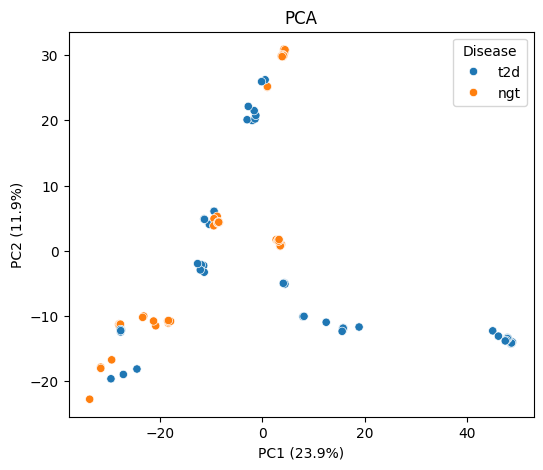

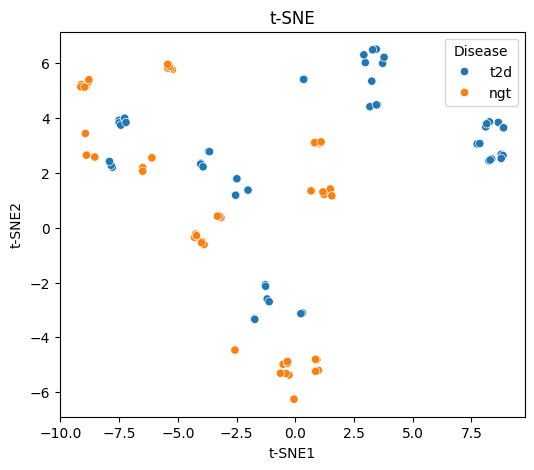

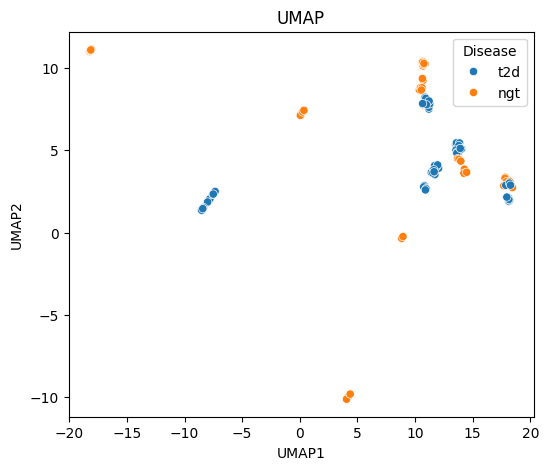

In [3]:
#FIXME remove before pushing
# ----- PCA only -----
plt.figure(figsize=(6,5))
sns.scatterplot(x=pca_coords[:,0], y=pca_coords[:,1], hue=labels)
plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)")
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)")
plt.title("PCA")
plt.legend(title="Disease")
plt.show()

# ----- t-SNE only -----
plt.figure(figsize=(6,5))
sns.scatterplot(x=tsne_coords[:,0], y=tsne_coords[:,1], hue=labels)
plt.xlabel("t-SNE1")
plt.ylabel("t-SNE2")
plt.title("t-SNE")
plt.legend(title="Disease")
plt.show()

# ----- UMAP only -----
plt.figure(figsize=(6,5))
sns.scatterplot(x=umap_coords[:,0], y=umap_coords[:,1], hue=labels)
plt.xlabel("UMAP1")
plt.ylabel("UMAP2")
plt.title("UMAP")
plt.legend(title="Disease")
plt.show()


## 3. Differential Analysis

In [ ]:
print(expr_log.head().to_string())

In [ ]:
print(meta.head().to_string())

d:\projects\cgs4144_project\.venv\lib\site-packages\scipy\stats\_axis_nan_policy.py:586: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


10000
20000
30000


d:\projects\cgs4144_project\.venv\lib\site-packages\bioinfokit\visuz.py:153: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['color_add_axy'].fillna(color[1], inplace=True)  # intermediate


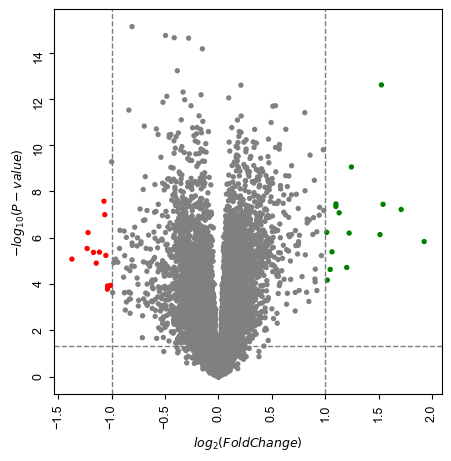

In [6]:
from scipy import stats
from bioinfokit import visuz

# Calculate log2 fold change
case   = meta.index[meta['refinebio_disease'] == 't2d'] # type 2 diabetes
expr_case = expr_log[case]

control = meta.index[meta['refinebio_disease'] == 'ngt'] # normal glucose tolerance
expr_control = expr_log[control]

expr_log['log2FC'] = expr_case.mean(axis=1) - expr_control.mean(axis=1) # log 2 fold change

# Calculate p-value using 2-sided t-test
pvals = []
c = 0 # counter
for gene in expr_log.index:
    t, p = stats.ttest_ind(expr_case.loc[gene], expr_control.loc[gene], equal_var=False)
    pvals.append(p)
    
    # increment and output counter
    c+=1
    if c % 10000 == 0:
        print(c)

expr_log['p-value'] = pvals # save to existing df

# Create volcano plot
visuz.GeneExpression.volcano(
    df=expr_log,
    lfc='log2FC',          # column with log2 fold-change
    pv='p-value',          # column with p-values
    lfc_thr=(1.0, 1.0),    # |log2FC| >= 1 considered significant
    pv_thr=(0.05, 0.05),   # p-value cutoff
    sign_line=True,        # draw threshold lines
    show=True              # display instead of saving to file
)

## 4. Significantly differentially expressed genes

In [ ]:
print(expr_log.head().to_string())
print(meta.head().to_string())

Significant genes: 27 

Starting plotting..
Starting calculating row orders..
Reordering rows..
Starting calculating col orders..
Reordering cols..
Plotting matrix..


d:\projects\cgs4144_project\.venv\lib\site-packages\PyComplexHeatmap\clustermap.py:835: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
d:\projects\cgs4144_project\.venv\lib\site-packages\PyComplexHeatmap\clustermap.py:835: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


Starting plotting HeatmapAnnotations
Plotting legends..
Estimated legend width: 19.051388888888887 mm


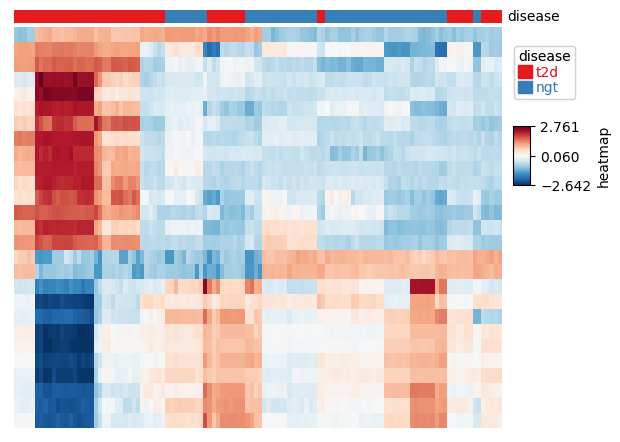

In [8]:
from PyComplexHeatmap import ClusterMapPlotter, HeatmapAnnotation

# Keep only significant genes
sig = expr_log[(expr_log["p-value"] < 0.05) & (expr_log["log2FC"].abs() >= 1)]
print("Significant genes:", sig.shape[0], '\n')
sample_cols = expr_log.columns.difference(["log2FC", "p-value"])
sig_expr = sig[sample_cols]

# z-score by gene
z_scores = (sig_expr - sig_expr.mean(axis=1).values[:, None]) / sig_expr.std(axis=1).values[:, None]

group_colors = {'t2d': '#E41A1C', 'ngt': '#377EB8'}

ha_col = HeatmapAnnotation(
    disease=meta.loc[z_scores.columns, 'refinebio_disease'],
    cmap=group_colors,
    legend=True,
    legend_kws={'title': 'Group'}
)

ClusterMapPlotter(
    data=z_scores,
    top_annotation=ha_col,
    row_cluster=True,
    col_cluster=True,
    cmap="RdBu_r",
    show_rownames=False
)
plt.show()

## 5. Gene enrichment analysis

i.	topGO

ii.	clustProfiler

iii.	gProfiler2

iv.	GenomicSuperSignature

v.	PyDESeq2 (BioStars example here)

vi.	Wilcoxon rank-sum test


### Sean - gProfiler2

Number of significant genes to test: 27
  source      native                              name       p_value  \
0  GO:BP  GO:0003012             muscle system process  6.880690e-11   
1  GO:BP  GO:0006936                muscle contraction  2.247026e-10   
2  GO:BP  GO:0055002  striated muscle cell development  5.635414e-10   
3  GO:BP  GO:0055001           muscle cell development  2.129222e-09   
4  GO:BP  GO:0030239                myofibril assembly  6.098492e-09   

   significant                                        description  term_size  \
0         True  "An organ system process carried out at the le...        438   
1         True  "A process in which force is generated within ...        349   
2         True  "The process whose specific outcome is the pro...        171   
3         True  "The process whose specific outcome is the pro...        198   
4         True  "Formation of myofibrils, the repeating units ...         76   

   query_size  intersection_size  effective_do

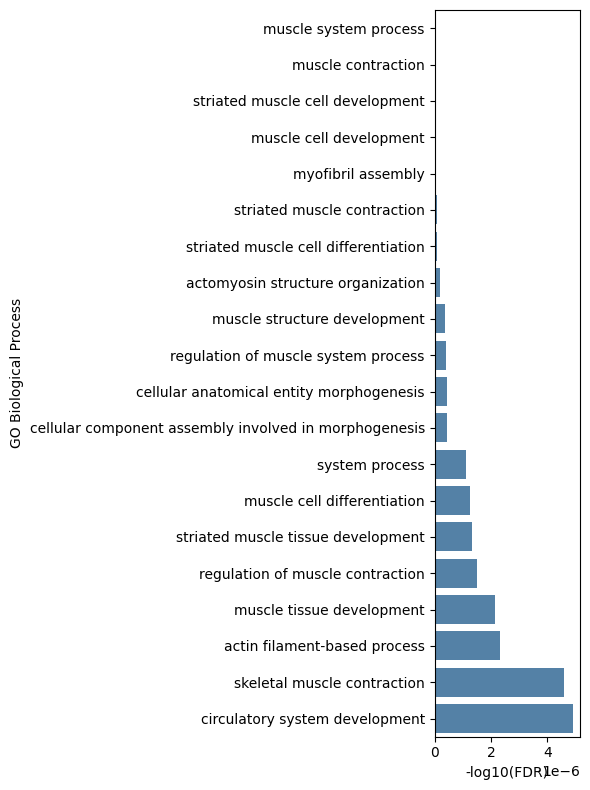

In [11]:
# gProfiler2
sig_genes = sig.index.tolist()
print("Number of significant genes to test:", len(sig_genes))

from gprofiler import GProfiler

gp = GProfiler(return_dataframe=True)
gost_results = gp.profile(
    organism='hsapiens',
    query=sig_genes,
    sources=['GO:BP'],
)

# Filter for FDR < 0.05
gost_sig = gost_results[gost_results['p_value'] < 0.05]
print(gost_sig.head())

# Save to your results folder
#gost_sig.to_csv("results/enrichment_GO_BP.csv", index=False)

import seaborn as sns
import matplotlib.pyplot as plt

top_terms = gost_sig.sort_values('p_value').head(20)
plt.figure(figsize=(6,8))
sns.barplot(
    data=top_terms,
    y='name',
    x='p_value',
    color='steelblue'
)
plt.xlabel('-log10(FDR)')
plt.ylabel('GO Biological Process')
plt.tight_layout()
plt.show()


### Daniel

In [1]:
# --------------
# Method Used: PyDESeq2 + gseapy (Enrichr backend)
# Ontology: GO_Biological_Process_2023
# --------------

import os
import pandas as pd
import numpy as np
from scipy.stats import wilcoxon
import gseapy as gp

in_path = "data/significant_genes.csv"
df = pd.read_csv(in_path)

gene_col_candidates = [c for c in ["GeneName", "Gene", "gene", "symbol", "Symbol"] if c in df.columns]
if not gene_col_candidates:
    raise ValueError(f"Couldn't find a gene symbol column in {df.columns.tolist()}.")
gene_col = gene_col_candidates[0]

gene_list_raw = df[gene_col].astype(str).str.strip()
gene_list = (
    gene_list_raw.replace({"nan": np.nan})
    .dropna()
    .str.upper()
    .tolist()
)
gene_list = sorted(set(gene_list))

print(f"Loaded {len(gene_list)} unique significant genes from '{gene_col}'")

if len(gene_list) < 5:
    raise ValueError("Need at least ~5 genes for stable enrichment. Check your input.")

out_dir = "results"
os.makedirs(out_dir, exist_ok=True)

enr = gp.enrichr(
    gene_list=gene_list,
    gene_sets=['GO_Biological_Process_2023'],
    organism='Human',
    cutoff=0.05,
    outdir=out_dir
)

res = enr.results.copy()
csv_path = os.path.join(out_dir, "GO_BP_results.csv")
res.to_csv(csv_path, index=False)
print(f"Saved full results to: {csv_path}")

display_cols = ["Term", "Adjusted P-value", "P-value", "Odds Ratio", "Combined Score", "Overlap"]
print(res[display_cols].head(10))

barplot_path = os.path.join(out_dir, "go_bp_barplot.png")
dotplot_path = os.path.join(out_dir, "go_bp_dotplot.png")

try:
    gp.barplot(res, title='GO Biological Process Enrichment', ofname=barplot_path, top_term=15)
    print(f"Barplot saved: {barplot_path}")
except Exception as e:
    print("Barplot generation skipped:", e)

try:
    gp.dotplot(res, title='GO Biological Process Enrichment', ofname=dotplot_path, top_term=15)
    print(f"Dotplot saved: {dotplot_path}")
except Exception as e:
    print("Dotplot generation skipped:", e)

if not res.empty:
    top = res.sort_values("Adjusted P-value").iloc[0]
    print(f"\nSummary: Ran GO BP enrichment on {len(gene_list)} genes. Top term: '{top['Term']}' (FDR q={top['Adjusted P-value']:.2e}).")
else:
    print("\nNo enriched GO BP terms at the chosen cutoff (q<=0.05).")


Loaded 27 unique significant genes from 'GeneName'
Saved full results to: results\GO_BP_results.csv
                                                Term  Adjusted P-value  \
0           Striated Muscle Contraction (GO:0006941)      2.217081e-08   
1      Regulation Of Muscle Contraction (GO:0006937)      3.377109e-08   
2           Skeletal Muscle Contraction (GO:0003009)      6.441613e-07   
3     Actomyosin Structure Organization (GO:0031032)      2.346706e-06   
4                Sarcomere Organization (GO:0045214)      2.346706e-06   
5                    Muscle Contraction (GO:0006936)      4.902314e-06   
6                    Myofibril Assembly (GO:0030239)      1.133819e-05   
7         Actin-Myosin Filament Sliding (GO:0033275)      1.149007e-05   
8  Regulation Of Striated Muscle Contraction (GO:...      1.670647e-04   
9   Cardiac Muscle Tissue Morphogenesis (GO:0055008)      1.846322e-04   

        P-value  Odds Ratio  Combined Score Overlap  
0  1.154730e-10  111.607843    

### Tatum

### Amilcar

Loaded 27 unique significant genes


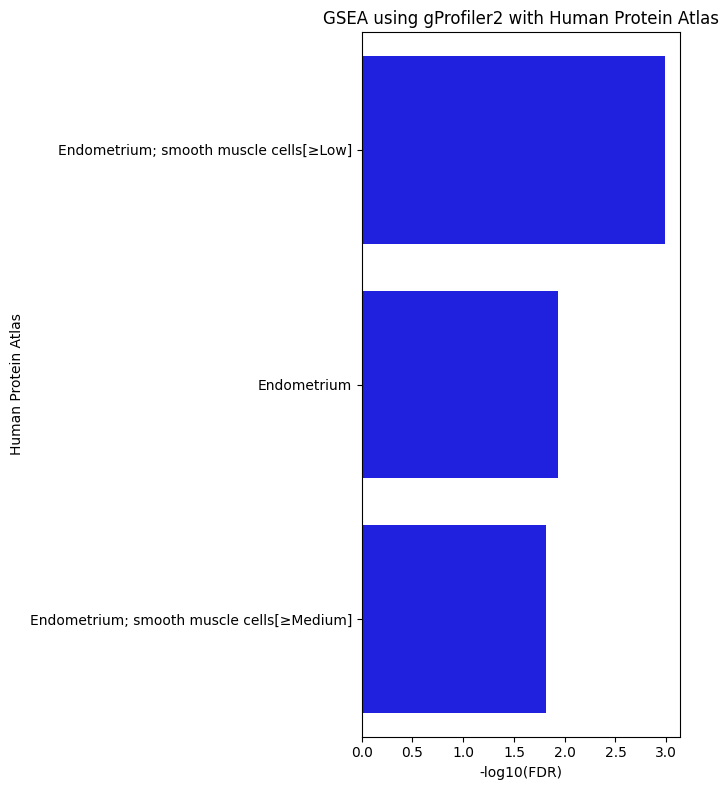

In [1]:
# Method: gProfiler2
# Ontology: Human Protein Atlas (HPA)

import numpy as np
import pandas as pd
from gprofiler import GProfiler
import matplotlib.pyplot as plt
import seaborn as sns

# Load genes
in_path = "data/significant_genes.csv"
df = pd.read_csv(in_path)

gene_col_candidates = [c for c in ["GeneName", "Gene", "gene", "symbol", "Symbol"] if c in df.columns]
gene_col = gene_col_candidates[0]

gene_list = df[gene_col].astype(str).str.strip().dropna().str.upper().tolist()
gene_list = sorted(set(gene_list))
print(f"Loaded {len(gene_list)} unique significant genes")

# Run gProfiler2 with HPA
gp = GProfiler(return_dataframe=True)

enr_results = gp.profile(
    organism = 'hsapiens',
    query = gene_list,
    sources = ['HPA'],   # Human Protein Atlas
)

# Filter by FDR < 0.05
sig_results = enr_results[enr_results['p_value'] < 0.05]

# Table Results
top_terms = sig_results.sort_values("p_value").head(15)

plt.figure(figsize=(7,8))
sns.barplot(
    data = top_terms,
    y = 'name',
    x = -top_terms['p_value'].apply(lambda p: np.log10(p)),
    color = 'blue'
)
plt.xlabel('-log10(FDR)')
plt.ylabel('Human Protein Atlas')
plt.title('GSEA using gProfiler2 with Human Protein Atlas')
plt.tight_layout()
plt.show()

### Joshua

Background size (expr ∩ library): n=11862

Top GO:MF terms (FDR BH):
                                                                            term  n_genes_in_term  median_in  median_out  median_diff      p_value      q_value
                                                      Actin Binding (GO:0003779)              182   0.092971    0.052556     0.040415 4.693216e-12 3.299331e-09
                                                   Cadherin Binding (GO:0045296)              317   0.082894    0.052387     0.030507 1.154199e-10 4.057009e-08
            Transmembrane Receptor Protein Tyrosine Kinase Activity (GO:0004714)               50   0.149507    0.052770     0.096737 4.344961e-10 1.018169e-07
                                   Protein Tyrosine Kinase Activity (GO:0004713)               99   0.108838    0.052704     0.056134 4.591128e-08 8.068907e-06
                                          GTPase Regulator Activity (GO:0030695)              422   0.072122    0.052491     0.0196

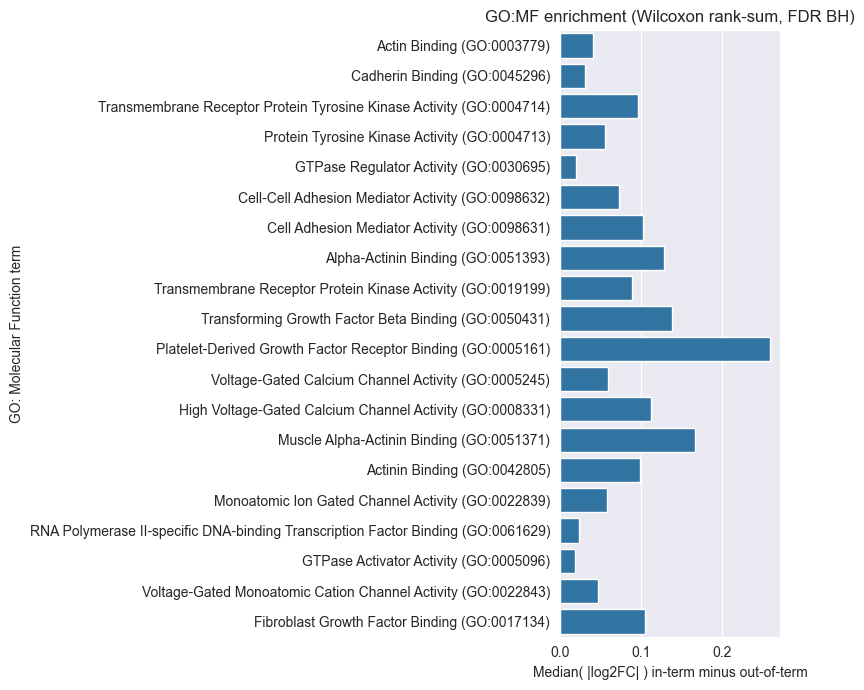

In [19]:
# using Wilcoxon rank sum on GO MF

import os
import numpy as np
import pandas as pd
from scipy.stats import mannwhitneyu
from statsmodels.stats.multitest import multipletests
import gseapy as gp
import seaborn as sns
import matplotlib.pyplot as plt

# align columns to the meta rows
sample_cols = meta.index.intersection(expr_log.columns)
if len(sample_cols) == 0:
    raise RuntimeError(
        "no overlap between sample IDs and expr_log columns"
    )

groups = meta.loc[sample_cols, 'refinebio_disease']

# define the two groups
case_label = 't2d'
ctrl_label = 'ngt'
if case_label not in groups.values or ctrl_label not in groups.values:
    raise RuntimeError(
        f"Expected group labels '{case_label}' and '{ctrl_label}' in meta['refinebio_disease'].\n"
        f"Found: {groups.unique().tolist()}"
    )

case_cols = groups.index[groups == case_label]
ctrl_cols = groups.index[groups == ctrl_label]

if 'log2FC' not in expr_log.columns:
    expr_log['log2FC'] = expr_log[case_cols].mean(axis=1) - expr_log[ctrl_cols].mean(axis=1)

# drop rows where log2FC is NA
expr_log = expr_log[expr_log['log2FC'].notna()]


score_col = "log2FC"
scores = expr_log[score_col].copy()
term_score = scores.abs()

# get GO MF gene sets from Enrichr via gseapy
library_name = "GO_Molecular_Function_2023"
go_lib = gp.get_library(name=library_name, organism="Human")  # dict: {term: [gene symbols]}

bg_all = pd.Index([g.upper() for g in term_score.index])
lib_genes = set(g.upper() for genes in go_lib.values() for g in genes)
background = bg_all.intersection(lib_genes)
print(f"Background size (expr ∩ library): n={len(background)}")
if len(background) < 50:
    raise RuntimeError(
        f"Very small background (n={len(background)}). "
    )

bg_scores = term_score.rename(index=str.upper).loc[background]
min_genes_in_term = 10
records = []
for term, genes in go_lib.items():
    term_genes = background.intersection([g.upper() for g in genes])
    if len(term_genes) < min_genes_in_term:
        continue

    in_scores = bg_scores.loc[list(term_genes)].values
    out_scores = bg_scores.loc[list(background.difference(term_genes))].values

    try:
        stat, pval = mannwhitneyu(in_scores, out_scores, alternative="greater")
    except ValueError: # if theyre all identical just skip
        continue

    eff = float(np.median(in_scores) - np.median(out_scores))

    records.append({
        "term": term,
        "n_genes_in_term": int(len(term_genes)),
        "median_in": float(np.median(in_scores)),
        "median_out": float(np.median(out_scores)),
        "median_diff": eff,
        "mw_stat": float(stat),
        "p_value": float(pval),
    })

res = pd.DataFrame.from_records(records).sort_values("p_value")
if res.empty:
    raise RuntimeError(
        "No testable GO:MF terms after size filter. "
    )

res["q_value"] = multipletests(res["p_value"], method="fdr_bh")[1]

# top results
topn = 20
top_terms = res.nsmallest(topn, "q_value").copy()
display_cols = ["term", "n_genes_in_term", "median_in", "median_out", "median_diff", "p_value", "q_value"]
print("\nTop GO:MF terms (FDR BH):")
print(top_terms[display_cols].to_string(index=False))

plt.figure(figsize=(8, 7))
sns.barplot(
    data=top_terms.sort_values("q_value"),
    y="term",
    x="median_diff"
)
plt.axvline(0, linestyle="--")
plt.xlabel("Median( |log2FC| ) in-term minus out-of-term")
plt.ylabel("GO: Molecular Function term")
plt.title("GO:MF enrichment (Wilcoxon rank-sum, FDR BH)")
plt.tight_layout()
plt.show()

# The data grid shows the genes that have the largest absolute fold changes than genes outside of it. positive median_diff, small p_val and small q_val mean that the term is enriched significantly (in terms of larger log2FC)
# the bar chart shows that the farther the value is above 0, the more the terms genes, in terms of median, change compared to the genomic background. It's sorted by statistical significance from the grid

## 6. Table of statistically significantly enriched terms

## 7. Combined table

## 8. Summary of each table/plot

## 9. Combine all results into a single file